# 🧙‍♂️ Sample Generation with Pretrained Model + LLLA

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jac-Zac/PML_DL_Final_Project/blob/master/notebooks/notebook_llla_diff.ipynb)

In [1]:
# NOTE: Initial import needed for Google Collab
# !pip install laplace-torch

### Initial setup ⚙️

In [2]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

In [3]:
if IN_COLAB:
    import os

    # !pip install laplace-torch -q
    repo_dir = "PML_DL_Final_Project"

    if not os.path.exists(repo_dir):
        !git clone https://github.com/Jac-Zac/PML_DL_Final_Project.git
    else:
        print(f"Repository '{repo_dir}' already exists. Skipping clone.")


    if os.path.isdir(repo_dir):
        %cd $repo_dir
        !pip install dotenv -q
    else:
        print(f"Directory '{repo_dir}' not found. Please clone the repository first.")

else:
    %cd ..

/Users/jaczac/Github/PML_DL_Final_Project


### 📦 Imports

In [4]:
from PIL import Image
import torch
import os

# from src.models.diffusion import UQDiffusion
from src.models.diffusion import Diffusion

from src.utils.data import get_llla_dataloader
from src.utils.plots import plot_interleaved_image_uncertainty, plot_uncertainty_sums
from src.utils.environment import get_device, set_seed, load_pretrained_model

/Users/jaczac/Github/PML_DL_Final_Project/src/models/diffusion.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### 🧪 Setup: Seed and Device

In [5]:
seed = 1337
set_seed(seed)
device = get_device()
os.makedirs("checkpoints", exist_ok=True)

## 💡 Image Generation

#### 🛠️ Configuration Parameters

In [6]:
n_samples = 5
sample_batch_size = 16
num_classes = 10
time_emb_dim = 128
save_dir = "samples"
model_name = "unet"
method = "diffusion"
ckpt_path = "jac-zac/bayesflow-project/best-model:v145"  # or use your last checkpoint
# ckpt_path = "jac-zac/bayesflow-project/best-model:v134"  # or use your last checkpoint
use_wandb = True
dataset_name = "FashionMNIST"

#### 📥 Load model and Dataloader

In [7]:
from src.models.llla_model import LaplaceApproxModel
from types import SimpleNamespace

model_kwargs = {
    "num_classes": num_classes,
    "time_emb_dim": time_emb_dim,
    # NOTE: Change time embedding to learned for flow which is more sensible
    "time_embedding_type": "mlp" if method == "flow" else "sinusoidal",
}


# Load pretrained MAP model using best checkpoint
diff_model = load_pretrained_model(
    model_name=model_name,
    # ckpt_path="jac-zac/diffusion-project/best-model:v80",
    ckpt_path=ckpt_path,
    device=device,
    model_kwargs=model_kwargs,
    use_wandb=use_wandb,
)

# Prepare data loaders for the Laplace fit
train_loader, _ = get_llla_dataloader(batch_size=sample_batch_size, dataset_name= dataset_name, mode = method)

mnist_config = SimpleNamespace()
mnist_config.data = SimpleNamespace()
mnist_config.data.image_size = 28  # MNIST image size

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: WARNING Unable to write /Users/jaczac/.config/netrc/netrc
wandb: Currently logged in as: jacopozac (jac-zac) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb:   1 of 1 files downloaded.  


### 💪 Fit Laplace approximation

In [8]:
# Wrap diffusion model with your Custom Model for Laplace last layer approx
# NOTE: Automatically call fit
laplace_model = LaplaceApproxModel(
    diff_model, train_loader, args=None, config=mnist_config
)

print("Laplace fitting completed on last layer of the diffusion model.")

Fitting Laplace:   0%|          | 0/3750 [00:00<?, ?it/s]

Laplace fitting completed on last layer of the diffusion model.


#### UQDiffusion

In [9]:
from typing import List, Optional, Tuple

import torch
from torch import Tensor, nn
from tqdm.notebook import tqdm

class UQDiffusion(Diffusion):
    """
    Diffusion model with uncertainty estimation capabilities.
    Extends the base Diffusion class to support Laplace approximation models.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def perform_training_step(
        self,
        model: nn.Module,
        x_0: Tensor,
        y: Optional[Tensor] = None,
        t: Optional[Tensor] = None,
    ) -> Tensor:
        """Override to use accurate_forward during training if available."""
        x_0 = x_0.to(self.device)
        if t is None:
            t = self._sample_timesteps(x_0.size(0))
        x_t, noise = self._sample_q(x_0, t)

        noise_pred = model(x_t, t, y=y)

        return self.loss_simple(noise, noise_pred)

    @torch.no_grad()
    def monte_carlo_covariance_estim(
        self,
        model: nn.Module,
        t: Tensor,
        x_mean: Tensor,
        x_var: Tensor,
        S: int = 100,
        y: Optional[Tensor] = None,
    ) -> Tensor:
        """
        Perform Monte Carlo sampling to estimate covariance matrix.
        Args:
            x_mean: Mean of x_0 estimated by diffusion.
            x_var: Variance of x_0 estimated by propagation.
            S: Number of Monte Carlo samples.

        Returns:
            covariance: Empirical diagonal covariance
        """

        std_x = torch.sqrt(torch.clamp(x_var, min=1e-12))
        x_samples = [x_mean + std_x * torch.randn_like(x_mean) for _ in range(S)]
        eps_samples = [model.accurate_forward(x_i, t, y=y) for x_i in x_samples]

        x_samples = torch.stack(x_samples, dim=0)  # [S, B, C, H, W]
        eps_samples = torch.stack(eps_samples, dim=0)  # [S, B, C, H, W]

        # Compute covariance with numerical stability
        x_centered = x_samples - x_mean.unsqueeze(0)
        v_centered = eps_samples - torch.mean(eps_samples, dim=0, keepdim=True)

        # NOTE: Compute the first term since second is 0 from the formula
        # And this avoids numerical instabilities
        covariance = torch.mean(x_centered * v_centered, dim=0)

        return covariance

    @torch.no_grad()
    def sample_with_uncertainty(
        self,
        model: nn.Module,
        channels: int = 1,
        y: Optional[Tensor] = None,
        cov_num_sample: int = 10,
        log_intermediate: bool = True,
    ) -> Tuple[Tensor, Tensor]:
        """
        Iteratively sample from the model, tracking predictive uncertainty and optionally Cov(x, ε).
        """
        model.eval()
        batch_size = 1 if y is None else y.size(0)

        x_t = torch.randn(
            batch_size, channels, self.img_size, self.img_size, device=self.device
        )

        x_t_mean = x_t.clone()
        x_t_var = torch.zeros_like(x_t)
        cov_t = torch.zeros_like(x_t)

        intermediates, uncertainties = [], []

        # for i in tqdm(range(self.noise_steps - 1, -1, -1), desc="Steps", leave=False):
        for i in tqdm(list(reversed(range(self.noise_steps))), desc="Steps", leave=False):
            t = torch.full((batch_size,), i, device=self.device, dtype=torch.long)

            # Predict noise and its variance
            eps_mean, eps_var = model(x_t, t, y=y)  # mean and variance of noise
            eps_t = eps_mean + torch.sqrt(eps_var) * torch.randn_like(eps_mean)

            # Compute xt-1
            beta_t = self.beta[t].view(-1, 1, 1, 1)
            alpha_t = self.alpha[t].view(-1, 1, 1, 1)
            alpha_bar_t = self.alpha_bar[t].view(-1, 1, 1, 1)

            # Mean and x_t-1
            coef1 = 1.0 / alpha_t.sqrt()
            coef2 = (1.0 - alpha_t) / (1.0 - alpha_bar_t).sqrt()
            x_prev_mean = coef1 * (x_t_mean - coef2 * eps_mean)
            x_prev = (
                coef1 * (x_t - coef2 * eps_t) + torch.randn_like(x_t) * beta_t.sqrt()
            )

            # Variance
            coef3 = 2 * (1 - alpha_t) / (alpha_t * (1 - alpha_bar_t).sqrt())
            coef4 = (1 - alpha_t) ** 2 / (alpha_t * (1 - alpha_bar_t))

            
            # x_prev_var = ((1 / alpha_t) * x_t_var) + (coef4 * eps_var) # + beta_t
            x_prev_var = ((1 / alpha_t) * x_t_var) - (coef3 * cov_t) + (coef4 * eps_var)#  + beta_t
            
            if i > 0:
                # Covariance estimation with Monte Carlo
                covariance = self.monte_carlo_covariance_estim(
                    model=model,
                    t=t - 1,
                    x_mean=x_prev_mean,
                    x_var=x_prev_var,
                    S=cov_num_sample,
                    y=y,
                )

            if i % 100 == 0 or i == self.noise_steps - 1:
                print(f"\nStep {i}")

                # eps_var: shape [B, C, H, W]
                # Reference slice
                # ref_slice = eps_var[0, 0]  # shape [H, W]
                
                # Compare each [H, W] slice to ref_slice
                # Broadcasting ref_slice to shape [B, C, H, W]
                
                # print(f"{(1 / alpha_t[0].item()) = }")
                # print(f"{(coef4[0].item()) = }")
                print( f"  eps_var mean: {eps_var.mean().item():.4e}, std: {eps_var.std().item():.4e}" )
                print( f"  Covariance mean: {cov_t.mean().item():.4e}, std: {cov_t.std().item():.4e}" )
                print( f"  x_t_var mean: {x_t_var.mean().item():.4e}, std: {x_t_var.std().item():.4e}" )
                print( f"  x_prev_var mean: {x_prev_var.mean().item():.4e}, std: {x_prev_var.std().item():.4e}" )

            # Log intermediate images
            if log_intermediate:
                intermediates.append(self.transform_sampled_image(x_t.clone()))
                uncertainties.append(x_prev_var.clone().cpu())  # per-pixel variance

            x_t = x_prev
            x_t_mean = x_prev_mean
            x_t_var = x_prev_var
            cov_t = covariance

        uncertainties = torch.stack(uncertainties)  # [num_steps, B, C, H, W]
        intermediates = torch.stack(intermediates)  # [num_steps, B, C, H, W]

        model.train()
        return intermediates, uncertainties


<!-- #region id="1d2b6a2d" -->
### 💨 Initialize Diffusion Process

In [10]:
# Since on a notebook we can have nicer bars
total_steps = 1000
n_samples = 10
cov_num_sample = 100
# cov_num_sample = 20


# Initialize uncertainty-aware diffusion (same interface as base class)
diffusion = UQDiffusion(noise_steps = total_steps, img_size=mnist_config.data.image_size, device=device)

# Generate samples and uncertainty for images for different classes
all_samples_grouped, uncertainties = diffusion.sample_with_uncertainty(
    model=laplace_model,
    # y=torch.arange(n_samples, device=device) % num_classes,
    y=torch.arange(n_samples, device=device) % num_classes,
    cov_num_sample=cov_num_sample,
    log_intermediate=True,
)

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]


Step 999
  eps_var mean: 9.7822e-07, std: 8.1211e-07
  Covariance mean: 0.0000e+00, std: 0.0000e+00
  x_t_var mean: 0.0000e+00, std: 0.0000e+00
  x_prev_var mean: 3.9929e-10, std: 3.3148e-10

Step 900
  eps_var mean: 9.5098e-07, std: 8.3895e-07
  Covariance mean: 1.3199e-08, std: 8.9996e-09
  x_t_var mean: 1.5823e-08, std: 1.1070e-08
  x_prev_var mean: 1.5944e-08, std: 1.1177e-08

Step 800
  eps_var mean: 8.6986e-07, std: 7.3592e-07
  Covariance mean: 1.2531e-08, std: 8.0497e-09
  x_t_var mean: 4.5882e-08, std: 3.3571e-08
  x_prev_var mean: 4.6448e-08, std: 3.3993e-08

Step 700
  eps_var mean: 8.2174e-07, std: 6.5620e-07
  Covariance mean: 1.7980e-08, std: 1.1072e-08
  x_t_var mean: 1.5699e-07, std: 1.1508e-07
  x_prev_var mean: 1.5888e-07, std: 1.1648e-07

Step 600
  eps_var mean: 9.5429e-07, std: 7.3912e-07
  Covariance mean: 2.8993e-08, std: 1.7355e-08
  x_t_var mean: 4.9890e-07, std: 3.6989e-07
  x_prev_var mean: 5.0442e-07, std: 3.7404e-07

Step 500
  eps_var mean: 1.0391e-06, st

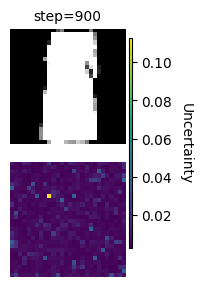

In [17]:
# Now call the interleaved plot function
plot_interleaved_image_uncertainty(
    images=all_samples_grouped[:, 3:4, ...],       # (T, B, C, H, W)
    uncertainties=uncertainties[:, 3:4, ...],      # (T, B, C, H, W)
    # images=all_samples_grouped,       # (T, B, C, H, W)
    # uncertainties=uncertainties,      # (T, B, C, H, W)
    save_path=os.path.join(save_dir, "interleaved_grid.png"),
    # timesteps=list(range(0, total_steps, 100)),
    timesteps=[900],
    uq_cmp="viridis",                 # Or "grey" or other matplotlib colormap
)

# Display samples grid images and uncertainty
out_path_img = os.path.join(save_dir, "interleaved_grid.png")
display(Image.open(out_path_img))

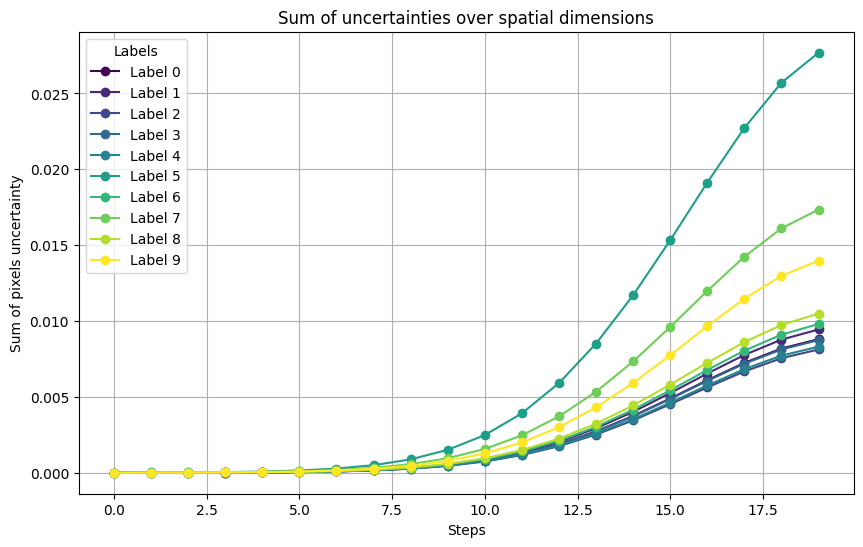

In [12]:
# plot_uncertainty_sums(uncertainties, samples=[0,2,5]), save_path="uncertainty_plot.png")  # save to file only specific samples
# Slice the first tensor dimension to only take every 50
plot_uncertainty_sums(uncertainties[::50, ...])  # all samples